# Analyse model
This notebook does analyses of the VAR model, to quantify its meaningfulness.

In [1]:
# To make relative imports work in notebooks
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# actual imports
from src.constants import YEARS, COL_STUDENT, COL_STUDENT_PRED, COL_SALARY, COL_SALARY_PRED, FIG_DIR, COURSES, SECTORS
from src.dataLoading import getTotalStudentsFor, getSalaries, getGraduatesInBwFor, getAllGraduatesYears, getInflationAdjustedGrossSalaries
from src.model import fitVarModelCompleteDataset, predictWithData
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tueplots import bundles

In [2]:
interestingYears = YEARS[3:-4]
totalStudents = getTotalStudentsFor(courses = COURSES, years = interestingYears)

inflationAdjustedGrossSalary= getInflationAdjustedGrossSalaries(SECTORS)
salaries = getSalaries()

years = getAllGraduatesYears()
years = years[37:52]
graduatesInBW = getGraduatesInBwFor(years = years)
newVal = (graduatesInBW[4] + graduatesInBW[6])/2

/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4
/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4


### Test model accuracy
Delete the last `PREDICTION_STEPS` timesteps and use them as a test set.

In [3]:
LAGS = 5
PREDICTION_STEPS = 10

In [4]:
completeData = np.column_stack((totalStudents, inflationAdjustedGrossSalary, graduatesInBW.repeat(2)))
trainData, testData = np.split(completeData, [len(completeData) - PREDICTION_STEPS])
completeDataDF = pd.DataFrame(completeData, index = YEARS[3:-4], columns = ['students', 'salary', 'graduates'])

In [5]:
results = fitVarModelCompleteDataset(completeData, LAGS)
forecast, lower, upper = predictWithData(results, trainData[-LAGS:], PREDICTION_STEPS)
print(forecast)

[[ 6493.99041825  3863.35457659 51584.63331644]
 [ 6851.5693526   3911.47823504 52630.86747667]
 [ 6188.85240027  3855.7474031  50772.21046777]
 [ 6729.31672372  3926.85369492 51718.02236417]
 [ 6160.5131601   3885.36631782 50830.53284299]
 [ 6813.34852387  3946.99180059 51347.42513739]
 [ 6179.51415698  3914.53776129 48514.7518586 ]
 [ 6688.46533565  3965.56620227 46465.70452222]
 [ 6097.50222639  3921.34441716 45489.70133057]
 [ 6566.87536272  3969.1824731  45577.05871915]]


In [6]:
print("These are the absoulue diffrences between the predicted and the actual values")
np.set_printoptions(suppress=True)
absDiffernce = abs(forecast - testData)
print(absDiffernce)

print("\nThese are the percentage differences between the predicted and the actual values")
percentage_difference = (absDiffernce / testData) * 100
print(percentage_difference)

These are the absoulue diffrences between the predicted and the actual values
[[  87.00958175    2.11712801  510.36668356]
 [  91.5693526     1.66658916  535.86747667]
 [  43.14759973   14.07910811  426.78953223]
 [  18.31672372   10.3818594   519.02236417]
 [  38.5131601    39.55550687 1685.53284299]
 [ 189.34852387   16.95688532 2202.42513739]
 [ 135.51415698   40.36268912 1917.7518586 ]
 [  91.46533565   19.95741869  131.29547778]
 [  37.49777361   12.59632908 1404.70133057]
 [  97.12463728    6.20938642 1492.05871915]]

These are the percentage differences between the predicted and the actual values
[[1.32213314 0.0548303  0.97968458]
 [1.35457622 0.04258951 1.02863514]
 [0.69235558 0.36381755 0.83358959]
 [0.27293583 0.26368398 1.01373535]
 [0.62909442 1.00780369 3.42971379]
 [2.8585224  0.42777762 4.48148365]
 [2.24212702 1.02057409 4.11561229]
 [1.38646863 0.50074772 0.28176809]
 [0.61121065 0.32225994 3.18634758]
 [1.45745254 0.15668505 3.3845043 ]]


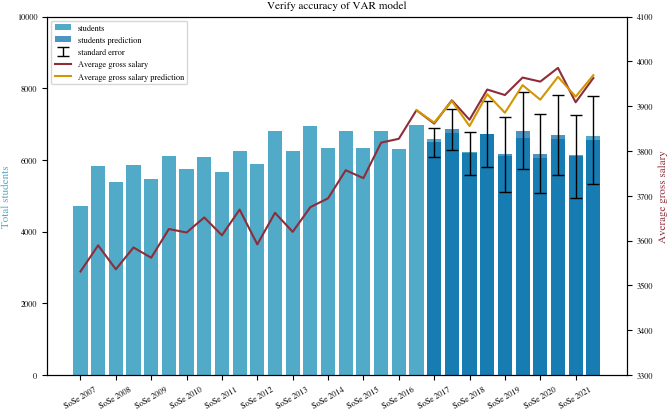

In [7]:
plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=1, usetex=False))
fig, ax1 = plt.subplots()
plt.title('Verify accuracy of VAR model')
plt.xticks(rotation=30)

ax1.set_ylim([0, 10000])
ax1.set_ylabel('Total students', color=COL_STUDENT)
ax1.bar(interestingYears[:-PREDICTION_STEPS], trainData[:, 0], color=COL_STUDENT, label='students')
ax1.bar(interestingYears[-PREDICTION_STEPS:], testData[:, 0], color=COL_STUDENT)
ax1.bar(interestingYears[-PREDICTION_STEPS:], forecast[:, 0], color=COL_STUDENT_PRED, alpha=0.7, label='students prediction')
ax1.errorbar(interestingYears[-PREDICTION_STEPS:], forecast[:, 0], yerr=upper[:, 0] - lower[:, 0], fmt='none', ecolor='k', elinewidth=1, capsize=4, label='standard error')

ax2 = ax1.twinx()  # instantiate a second ax that shares the same x-axis
forecastWithPrevious = np.concatenate((trainData[-1, :].reshape(1, -1), forecast))

ax2.set_ylim([3300, 4100])
ax2.set_ylabel('Average gross salary', color=COL_SALARY)
ax2.plot(interestingYears, completeData[:, 1], color=COL_SALARY, label='Average gross salary')
ax2.plot(interestingYears[-PREDICTION_STEPS -1:], forecastWithPrevious[:, 1], color=COL_SALARY_PRED, label='Average gross salary prediction')


# Create one legend for both subplots
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Get current ticks, keep only every second tick
locs, labels = plt.xticks()
plt.xticks(locs[::2], labels[::2])
fig.savefig(FIG_DIR + f"/prediction_{LAGS}.pdf")
plt.show()

In [8]:
with open('summary.txt', 'w') as file:
    file.write(str(results.summary()))

## Analysis of the correlation matrix of the residuals

<Axes: >

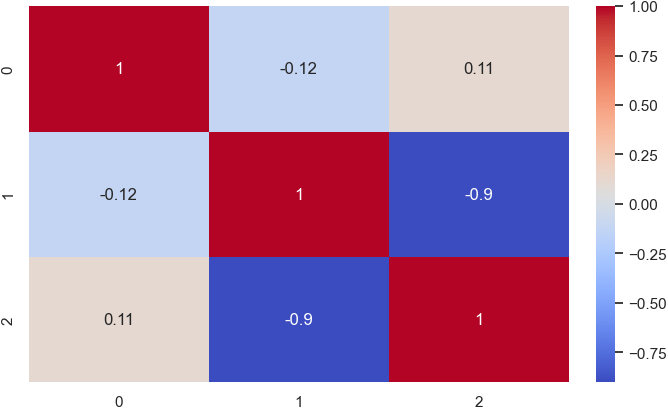

In [9]:
import seaborn as sns
resudiuals = results.resid
correlationMatrix = np.corrcoef(resudiuals, rowvar=False)
sns.set(style="white")
sns.heatmap(correlationMatrix, cmap="coolwarm", annot=True, )

In [10]:
print(results.test_causality(caused='y1', causing=['y2', 'y3'], kind='f'))
# results.names

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ['y2', 'y3'] do not Granger-cause y1: reject at 5% significance level. Test statistic: 3.972, critical value: 2.204>, p-value: 0.002>
